# # Apresentação # #

**Nome**: Guilherme Marinho de Araujo

**Email**: guilherme.araujo.0798@gmail.com

**Objetivo**: Sub classificar as categorias da base transacional da Justa através de um modelo de clusterização

# # 0. Importando Bibliotecas#

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, scale, PowerTransformer
from yellowbrick.cluster import kelbow_visualizer, SilhouetteVisualizer, KElbowVisualizer, silhouette_visualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# #1. Análise Iniciais# 

In [ ]:
# Foi feita aqui a leitura dos dados dispostos no formato excel.
df = pd.read_excel('/content/AnaliseExploratoriaJusta.xlsx')
df.head()

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
0,44,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,52.0
1,44,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,54.0
2,90,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,21.0
3,94,2022-01-01,1,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,NaN
4,94,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,NaN


In [ ]:
df.rec_est_id.value_counts()

44       14
21547    14
17777    14
17826    14
18915    14
         ..
30244     1
30332     1
29944     1
30063     1
29128     1
Name: rec_est_id, Length: 19740, dtype: int64

In [ ]:
#Verificação de dados nulos e de formatação das features.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205363 entries, 0 to 205362
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   rec_est_id                        205363 non-null  int64         
 1   rec_month                         205363 non-null  datetime64[ns]
 2   rec_month_part                    205363 non-null  int64         
 3   rec_year_part                     205363 non-null  int64         
 4   rec_month_mf_antecipated          205363 non-null  float64       
 5   rec_month_mf_not_antecipated      205363 non-null  float64       
 6   rec_month_mf                      205363 non-null  float64       
 7   rec_previous_month_mf             205363 non-null  float64       
 8   rec_previous_month_mf_delta       205363 non-null  float64       
 9   rec_month_qtd_mov                 205363 non-null  int64         
 10  rec_previous_month_qtd_mov      

1. Pode ser verificar acima que a única coluna com dados nulos é a **'rec_registered_month'**. 
2. Será feita uma análise em breve sobre esse valores nulos. 
3. Há, ao todo, 6881 linhas nulas nessa coluna.

In [ ]:
#Verificando a quantidade de cada categoria dos lojistas.

df.rec_monthly_category.value_counts()

Churn          103883
Nunca Mov       77845
Recorrente      13494
Perda            5728
Novo             2917
Recuperação      1496
Name: rec_monthly_category, dtype: int64

In [ ]:
# Descrevendo os dados numéricos da tabela. 

df.describe()

,rec_est_id,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_registered_month
count,205363.000000,205363.000000,205363.000000,205363.000000,205363.000000,205363.000000,2.053630e+05,2.053630e+05,205363.000000,205363.000000,205363.000000,205363.000000,198482.000000
mean,16192.857151,6.022818,2022.168268,838.751317,264.590464,1103.341782,1.176913e+03,-7.357144e+01,7.934803,7.554691,0.380112,55.288435,15.569235
std,8000.191654,3.720818,0.374105,10447.973896,5534.041225,11844.972641,1.327662e+04,9.523235e+03,88.662964,84.427350,49.667954,541.450629,10.986566
min,1.000000,1.000000,2022.000000,0.000000,0.000000,0.000000,0.000000e+00,-1.706322e+06,0.000000,0.000000,-3292.000000,0.000000,0.000000
25%,9122.000000,2.000000,2022.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,6.000000
50%,17475.000000,6.000000,2022.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,15.000000
75%,22786.500000,9.000000,2022.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,22.000000
max,30519.000000,12.000000,2023.000000,814475.400000,588157.520000,814475.400000,1.855201e+06,6.345732e+05,6955.000000,6955.000000,3026.000000,51683.520000,59.000000


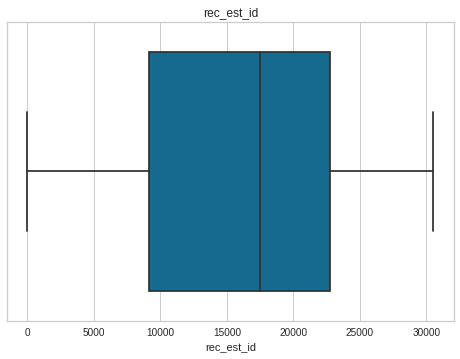

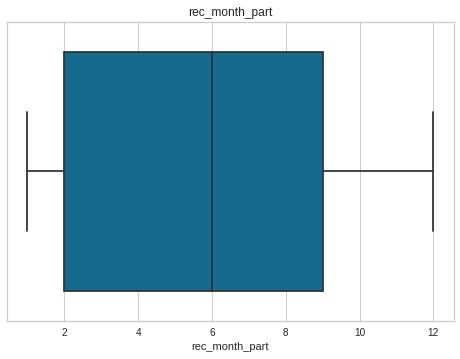

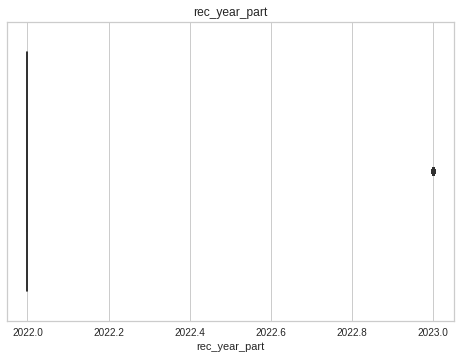

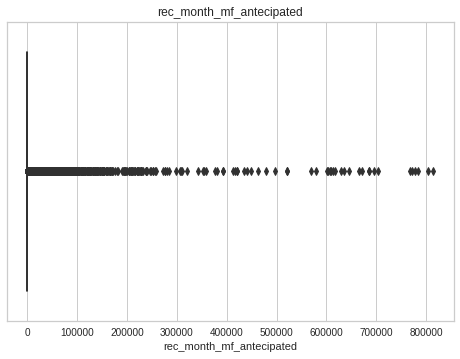

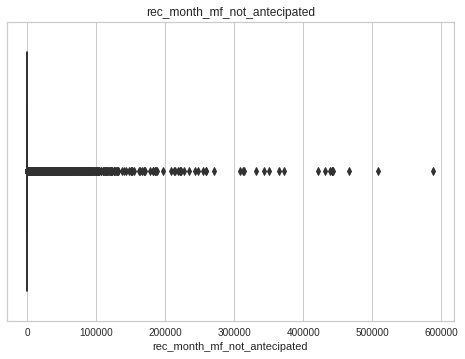

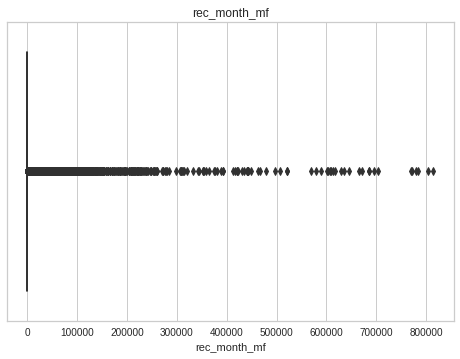

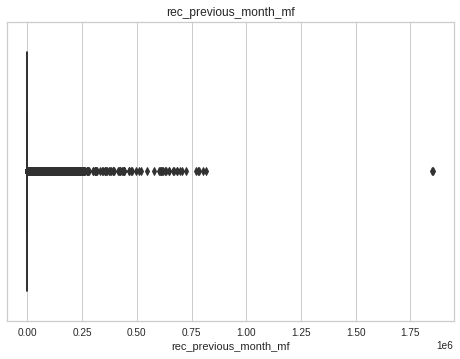

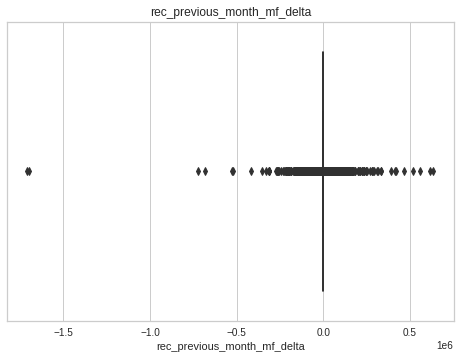

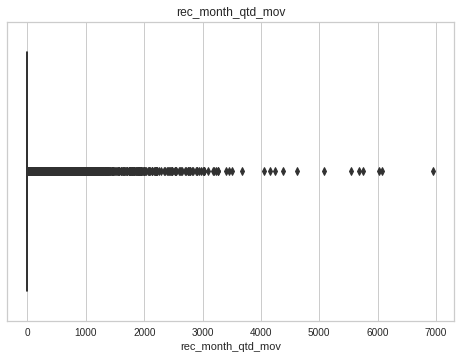

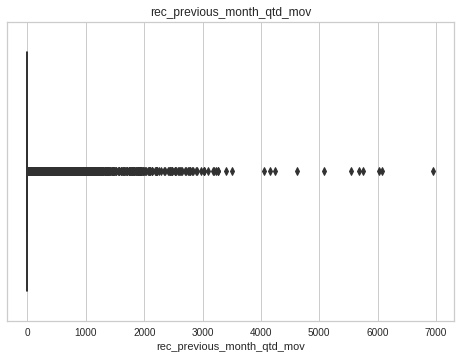

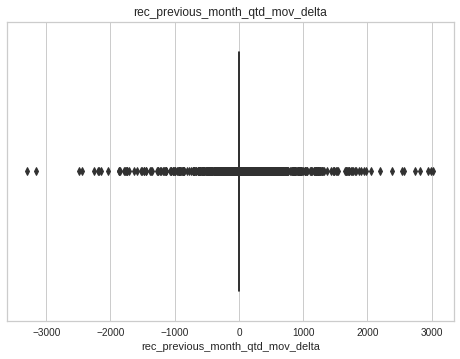

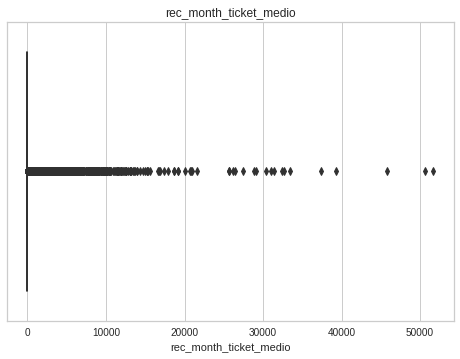

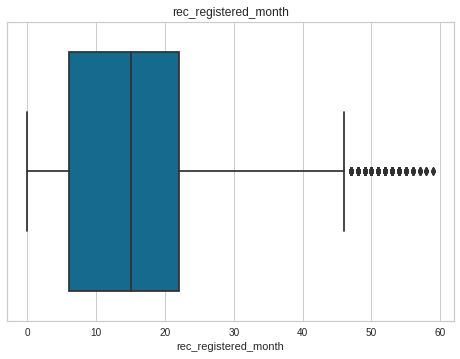

In [ ]:
# selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()

# criar um gráfico boxplot para cada coluna numérica
for col in numeric_cols:
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

Como pode ser verificado acima, devido ao banco de dados guardar as informações dos clientes, mesmo eles estando inativos, a quantidade de zeros distribuídos nas colunas referentes a valores de transação é muito alta. Logo, para uma melhor análise dos dados, será feita uma outra organização.

In [ ]:
# Identificando onde está o começo da análise e verificando que o começo se refere ao mês de janeiro de 2022.
df.sort_values(by='rec_month')

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
81997,9729,2022-01-01,1,2022,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Churn,15.0
39026,5469,2022-01-01,1,2022,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Churn,23.0
125163,21308,2022-01-01,1,2022,6670.81,0.0,6670.81,0.0,6670.81,5,0,5,1334.16,Recuperação,4.0
39019,4793,2022-01-01,1,2022,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Churn,24.0
162576,10422,2022-01-01,1,2022,0.00,0.0,0.00,410.0,-410.00,0,4,-4,0.00,Perda,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28770,23040,2023-02-01,2,2023,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Churn,10.0
28769,23026,2023-02-01,2,2023,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Nunca Mov,10.0
28768,23023,2023-02-01,2,2023,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Nunca Mov,10.0
28778,23116,2023-02-01,2,2023,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Churn,10.0


In [ ]:
# Criando uma tabela que verifica a quantidade de ocorrências de cada ID em cada mês
contagem = df.groupby(['rec_est_id', 'rec_month']).size().reset_index(name='Contagem')

contagem

,rec_est_id,rec_month,Contagem
0,1,2022-01-01,1
1,1,2022-02-01,1
2,1,2022-03-01,1
3,1,2022-04-01,1
4,1,2022-05-01,1
...,...,...,...
205358,30515,2023-02-01,1
205359,30516,2023-02-01,1
205360,30517,2023-02-01,1
205361,30518,2023-02-01,1


In [ ]:
# Verificando se há algum cliente que consta mais de uma vez em um determinado mês.

contagem[contagem['Contagem']>1]

,rec_est_id,rec_month,Contagem


# # 2. Análise exploratória / Entedimento dos dados . #

In [ ]:
df_churn = df[df['rec_monthly_category']=='Churn']

In [ ]:
df_churn

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
0,44,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,52.0
1,44,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,54.0
2,90,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,21.0
5,109,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,48.0
6,111,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203767,28230,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,2.0
203770,28232,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,2.0
203787,28237,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,2.0
203985,28306,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,2.0


In [ ]:
df_churn[df_churn['rec_est_id']==111]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
6,111,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,52.0
30925,111,2022-12-01,12,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,53.0
31496,111,2023-02-01,2,2023,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,55.0
31502,111,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,44.0
41737,111,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,46.0
70869,111,2022-02-01,2,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,43.0
74862,111,2022-01-01,1,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,42.0
74863,111,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,47.0
90064,111,2023-01-01,1,2023,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,54.0
90163,111,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,49.0


Como pode ser verificado acima, existem alguns clientes classificados como **'churn'** que durante o período analisado estiveram sempre inativos, sendo, por conseguinte, o período que estiveram ativos anterior aos registros no dataset fornecido para o teste. Sabe-se que eles são clientes que alguma vez já realizaram transação, uma vez que os lojistas que nunca realizaram foram identificados com **'Nunca Mov'**, entretanto, como não se tem informações de transação sobre esses clientes, os mesmo serão removidos da análise em breve assim como os que nunca realizaram movimentação.

In [ ]:
# Verificando se todos os clientes que foram churn realmente possuem transação igual a zero.
df_churn[df_churn['rec_month_ticket_medio']>0]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month


In [ ]:
# Verificando o comportamento de um cliente específico
df[df['rec_est_id']==20267]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
11955,20267,2023-02-01,2,2023,0.00,0.0,0.00,156.42,-156.42,0,2,-2,0.00,Perda,19.0
29419,20267,2022-12-01,12,2022,0.00,0.0,0.00,0.00,0.00,0,0,0,0.00,Churn,17.0
51497,20267,2022-02-01,2,2022,0.00,0.0,0.00,94.00,-94.00,0,1,-1,0.00,Perda,7.0
63683,20267,2023-01-01,1,2023,156.42,0.0,156.42,0.00,156.42,2,0,2,78.21,Recuperação,18.0
86098,20267,2022-05-01,5,2022,0.01,0.0,0.01,324.33,-324.32,1,2,-1,0.01,Recorrente,10.0
103577,20267,2022-04-01,4,2022,324.33,0.0,324.33,0.00,324.33,2,0,2,162.17,Recuperação,9.0
109710,20267,2022-03-01,3,2022,0.00,0.0,0.00,0.00,0.00,0,0,0,0.00,Churn,8.0
119434,20267,2022-07-01,7,2022,0.00,0.0,0.00,0.00,0.00,0,0,0,0.00,Churn,12.0
148738,20267,2022-09-01,9,2022,0.00,0.0,0.00,388.89,-388.89,0,2,-2,0.00,Perda,14.0
167699,20267,2022-08-01,8,2022,388.89,0.0,388.89,0.00,388.89,2,0,2,194.45,Recuperação,13.0


Será feito um breve estudo sobre os clientes que nunca realizaram movimentação a fim de validar se existe alguma informação relevante para considerá-los na análise. De ante mão, o autor não identifica necessidade desses dados fazerem parte do modelo.

In [ ]:
df_nunca_mov = df[df['rec_monthly_category']=='Nunca Mov']

In [ ]:
df_nunca_mov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77845 entries, 3 to 205362
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rec_est_id                        77845 non-null  int64         
 1   rec_month                         77845 non-null  datetime64[ns]
 2   rec_month_part                    77845 non-null  int64         
 3   rec_year_part                     77845 non-null  int64         
 4   rec_month_mf_antecipated          77845 non-null  float64       
 5   rec_month_mf_not_antecipated      77845 non-null  float64       
 6   rec_month_mf                      77845 non-null  float64       
 7   rec_previous_month_mf             77845 non-null  float64       
 8   rec_previous_month_mf_delta       77845 non-null  float64       
 9   rec_month_qtd_mov                 77845 non-null  int64         
 10  rec_previous_month_qtd_mov        77845 non-n

In [ ]:
df[df['rec_est_id']==294]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
29,294,2022-04-01,4,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,36.0
14083,294,2022-12-01,12,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,44.0
20622,294,2023-02-01,2,2023,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,46.0
23855,294,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,39.0
43984,294,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,37.0
53173,294,2022-09-01,9,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,41.0
57338,294,2023-01-01,1,2023,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,45.0
70981,294,2022-01-01,1,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,33.0
71006,294,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,38.0
74941,294,2022-02-01,2,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,34.0


In [ ]:
# Como pode-se observar abaixo os únicos dados nulos da tabela se referem aos lojistas que nunca fizeram movimentação.

df[df.rec_registered_month.isna()].rec_monthly_category.value_counts()

Nunca Mov    6881
Name: rec_monthly_category, dtype: int64

Removendo as linhas com os lojitas classificados como **'Nunca Mov'**

In [ ]:
df = df[~(df['rec_monthly_category']=='Nunca Mov')]

In [ ]:
# Identificar os IDs que possuem única e exclusivamente o valor 'Churn' na coluna de rec_registered_month
id_to_remove = df.groupby('rec_est_id')['rec_monthly_category'].unique().apply(lambda x: len(x) == 1 and 'Churn' in x).loc[lambda x: x].index

# Nesse código, é feito um filtro selecionando os ids que possuem apenas um valor único como categoria e essa valor é justamente 'Churn'.

# Remover as linhas desses IDs do dataframe
df = df[~df['rec_est_id'].isin(id_to_remove)]


In [ ]:
df

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
5,109,2022-07-01,7,2022,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Churn,48.0
7,113,2022-11-01,11,2022,6094.09,0.0,6094.09,8781.8,-2687.71,61,66,-5,99.90,Recorrente,52.0
8,115,2022-11-01,11,2022,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Churn,52.0
12,121,2022-08-01,8,2022,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Churn,33.0
13,121,2022-10-01,10,2022,0.00,0.0,0.00,0.0,0.00,0,0,0,0.00,Churn,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205242,29141,2022-11-01,11,2022,1.00,0.0,1.00,0.0,1.00,1,0,1,1.00,Novo,0.0
205258,29168,2022-11-01,11,2022,108.56,0.0,108.56,0.0,108.56,3,0,3,36.19,Novo,0.0
205293,29182,2022-11-01,11,2022,19.81,0.0,19.81,0.0,19.81,2,0,2,9.91,Novo,0.0
205295,29184,2022-11-01,11,2022,0.10,0.0,0.10,0.0,0.10,1,0,1,0.10,Novo,0.0


In [ ]:
df[df['rec_est_id']==121]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
12,121,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,33.0
13,121,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,35.0
6126,121,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,30.0
21889,121,2023-02-01,2,2023,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,39.0
41744,121,2022-01-01,1,2022,10681.0,0.0,10681.0,11824.4,-1143.4,84,87,-3,127.15,Recorrente,26.0
41745,121,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,31.0
52947,121,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,28.0
90265,121,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,36.0
95025,121,2023-01-01,1,2023,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,38.0
113825,121,2022-12-01,12,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,37.0


In [ ]:
df[df['rec_est_id']==111]

# Podemos verificar que a remoção foi feita com sucesso. Note que não foram removidos todos lojista que já foram churns e sim os lojistas que possuíam todos as suas linhas exclusivamente iguais a Churn nesse dataset em relação à coluna de categoria.

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month


In [ ]:
#Verificar a quantidade de clientes no dataset geral.
df.rec_est_id.value_counts()

109      14
13742    14
12047    14
12079    14
12313    14
         ..
30163     1
30248     1
30254     1
30255     1
30197     1
Name: rec_est_id, Length: 6469, dtype: int64

In [ ]:
# Verificar quantos registros possuem no último mês de verificação.
df[df['rec_month']=='2023-02-01'].rec_est_id.value_counts()

28502    1
30503    1
26832    1
26805    1
26755    1
        ..
15985    1
15652    1
15368    1
15192    1
30425    1
Name: rec_est_id, Length: 5642, dtype: int64

In [ ]:
# Ordenar primeiramente o dataset pelo ID e depois pelo mes de registro. Ambas ordenações são crescentes.
df = df.sort_values(by=["rec_est_id", "rec_registered_month"], ascending=[True, True])

In [ ]:
# Visualizando o dataset após a ordenação.
df.head(50)

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
185071,1,2022-01-01,1,2022,838.80,0.00,838.80,0.00,838.80,5,0,5,167.76,Recuperação,24.0
185067,1,2022-02-01,2,2022,7802.59,0.00,7802.59,838.80,6963.79,93,5,88,83.90,Recorrente,25.0
190800,1,2022-03-01,3,2022,2.00,0.00,2.00,7802.59,-7800.59,2,93,-91,1.00,Recorrente,26.0
185070,1,2022-04-01,4,2022,0.00,1000.00,1000.00,2.00,998.00,1,2,-1,1000.00,Recorrente,27.0
192772,1,2022-05-01,5,2022,0.00,1165.74,1165.74,1000.00,165.74,2,1,1,582.87,Recorrente,28.0
185072,1,2022-06-01,6,2022,0.00,10.56,10.56,1165.74,-1155.18,1,2,-1,10.56,Recorrente,29.0
185069,1,2022-07-01,7,2022,0.00,0.00,0.00,10.56,-10.56,0,1,-1,0.00,Perda,30.0
185073,1,2022-08-01,8,2022,0.00,6370.07,6370.07,0.00,6370.07,9,0,9,707.79,Recuperação,31.0
185068,1,2022-09-01,9,2022,0.00,15417.18,15417.18,6370.07,9047.11,17,9,8,906.89,Recorrente,32.0
185074,1,2022-10-01,10,2022,0.00,10740.41,10740.41,15417.18,-4676.77,11,17,-6,976.40,Recorrente,33.0


In [ ]:
df.iloc[60000:60050]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
19113,28900,2023-02-01,2,2023,0.00,0.00,0.00,56.00,-56.00,0,2,-2,0.00,Perda,3.0
205006,28910,2022-11-01,11,2022,8385.80,0.00,8385.80,0.00,8385.80,12,0,12,698.82,Novo,0.0
15611,28910,2022-12-01,12,2022,11401.60,0.00,11401.60,8385.80,3015.80,63,12,51,180.98,Recorrente,1.0
57190,28910,2023-01-01,1,2023,1368.30,0.00,1368.30,11401.60,-10033.30,11,63,-52,124.39,Recorrente,2.0
17507,28910,2023-02-01,2,2023,5562.19,0.00,5562.19,1368.30,4193.89,46,11,35,120.92,Recorrente,3.0
205005,28911,2022-11-01,11,2022,9886.32,0.00,9886.32,0.00,9886.32,8,0,8,1235.79,Novo,0.0
128245,28911,2022-12-01,12,2022,24518.19,0.00,24518.19,9886.32,14631.87,24,8,16,1021.59,Recorrente,1.0
96675,28911,2023-01-01,1,2023,2125.26,0.00,2125.26,24518.19,-22392.93,4,24,-20,531.32,Recorrente,2.0
23180,28911,2023-02-01,2,2023,0.00,0.00,0.00,2125.26,-2125.26,0,4,-4,0.00,Perda,3.0
205013,28916,2022-11-01,11,2022,4963.31,0.00,4963.31,0.00,4963.31,128,0,128,38.78,Novo,0.0


Fazendo uma análise do último mês de registro.

In [ ]:
df_atual = df[df['rec_month']=='2023-02-01']

In [ ]:
df_atual

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
12556,1,2023-02-01,2,2023,3760.31,14226.63,17986.94,5144.85,12842.09,21,5,16,856.52,Recorrente,37.0
10187,49,2023-02-01,2,2023,0.00,0.00,0.00,99.00,-99.00,0,1,-1,0.00,Perda,58.0
10188,89,2023-02-01,2,2023,0.00,0.00,0.00,0.00,0.00,0,0,0,0.00,Churn,57.0
19207,109,2023-02-01,2,2023,5.50,0.00,5.50,0.00,5.50,1,0,1,5.50,Recuperação,55.0
20616,112,2023-02-01,2,2023,0.00,0.00,0.00,0.00,0.00,0,0,0,0.00,Churn,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10161,30481,2023-02-01,2,2023,5.00,0.00,5.00,0.00,5.00,1,0,1,5.00,Novo,0.0
29508,30484,2023-02-01,2,2023,0.10,0.00,0.10,0.00,0.10,1,0,1,0.10,Novo,0.0
26034,30503,2023-02-01,2,2023,110.00,0.00,110.00,0.00,110.00,1,0,1,110.00,Novo,0.0
23302,30504,2023-02-01,2,2023,0.01,0.00,0.01,0.00,0.01,1,0,1,0.01,Novo,0.0


In [ ]:
df_atual.rec_monthly_category.value_counts()

Churn          3593
Recorrente     1498
Perda           245
Novo            198
Recuperação     108
Name: rec_monthly_category, dtype: int64

In [ ]:
df['rec_new_category'] = 'Inativo'
 
df.loc[df['rec_monthly_category'] == 'Novo', 'rec_new_category'] = 'Ativo'
df.loc[df['rec_monthly_category'] == 'Recorrente', 'rec_new_category'] = 'Ativo'
df.loc[df['rec_monthly_category'] == 'Recuperação', 'rec_new_category'] = 'Ativo'

In [ ]:
df.head(50)

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_new_category
185071,1,2022-01-01,1,2022,838.80,0.00,838.80,0.00,838.80,5,0,5,167.76,Recuperação,24.0,Ativo
185067,1,2022-02-01,2,2022,7802.59,0.00,7802.59,838.80,6963.79,93,5,88,83.90,Recorrente,25.0,Ativo
190800,1,2022-03-01,3,2022,2.00,0.00,2.00,7802.59,-7800.59,2,93,-91,1.00,Recorrente,26.0,Ativo
185070,1,2022-04-01,4,2022,0.00,1000.00,1000.00,2.00,998.00,1,2,-1,1000.00,Recorrente,27.0,Ativo
192772,1,2022-05-01,5,2022,0.00,1165.74,1165.74,1000.00,165.74,2,1,1,582.87,Recorrente,28.0,Ativo
185072,1,2022-06-01,6,2022,0.00,10.56,10.56,1165.74,-1155.18,1,2,-1,10.56,Recorrente,29.0,Ativo
185069,1,2022-07-01,7,2022,0.00,0.00,0.00,10.56,-10.56,0,1,-1,0.00,Perda,30.0,Inativo
185073,1,2022-08-01,8,2022,0.00,6370.07,6370.07,0.00,6370.07,9,0,9,707.79,Recuperação,31.0,Ativo
185068,1,2022-09-01,9,2022,0.00,15417.18,15417.18,6370.07,9047.11,17,9,8,906.89,Recorrente,32.0,Ativo
185074,1,2022-10-01,10,2022,0.00,10740.41,10740.41,15417.18,-4676.77,11,17,-6,976.40,Recorrente,33.0,Ativo


In [ ]:
df_ativo = df[~((df['rec_monthly_category']=='Churn') | (df['rec_monthly_category']=='Perda') )]

In [ ]:
df_ativo.rec_monthly_category.value_counts()

Recorrente     13494
Novo            2917
Recuperação     1496
Name: rec_monthly_category, dtype: int64

In [ ]:
df_ativo.describe()

,rec_est_id,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_registered_month
count,17907.000000,17907.000000,17907.000000,17907.000000,17907.000000,17907.000000,1.790700e+04,1.790700e+04,17907.000000,17907.000000,17907.000000,17907.000000,17907.000000
mean,21328.737756,5.560563,2022.198302,9619.058847,3034.405067,12653.463914,1.212844e+04,5.250276e+02,90.998771,80.785615,10.213157,634.064823,8.408723
std,7908.541910,4.067859,0.398732,34168.452969,18515.849015,38248.754443,4.214975e+04,3.043252e+04,287.400796,270.492688,159.619588,1730.699049,9.135097
min,1.000000,1.000000,2022.000000,0.000000,0.000000,0.010000,0.000000e+00,-1.706322e+06,1.000000,0.000000,-3292.000000,0.010000,0.000000
25%,17023.500000,2.000000,2022.000000,53.000000,0.000000,650.000000,1.000000e-02,-1.490285e+03,3.000000,1.000000,-5.000000,52.005000,2.000000
50%,24620.000000,5.000000,2022.000000,1800.000000,0.000000,3421.000000,2.475880e+03,1.490000e+02,11.000000,8.000000,1.000000,169.910000,5.000000
75%,27479.000000,10.000000,2022.000000,8305.500000,0.000000,11442.355000,1.043499e+04,2.659645e+03,55.000000,47.000000,8.000000,558.415000,13.000000
max,30507.000000,12.000000,2023.000000,814475.400000,588157.520000,814475.400000,1.855201e+06,6.345732e+05,6955.000000,6955.000000,3026.000000,51683.520000,57.000000


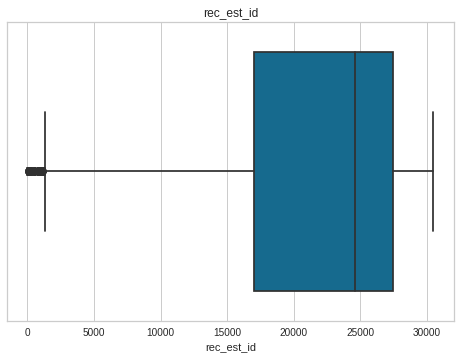

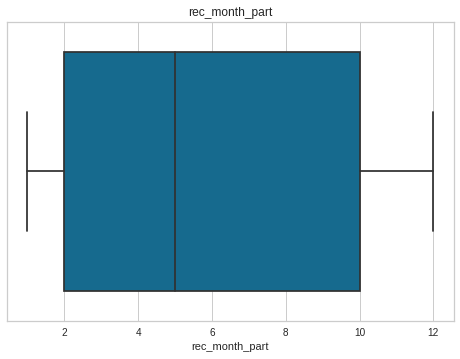

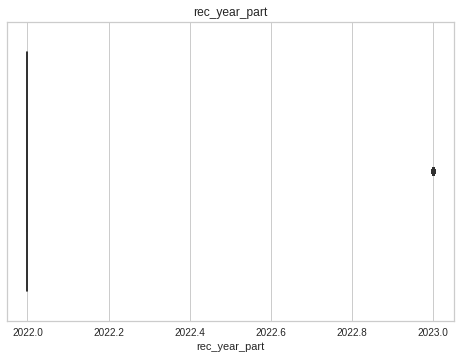

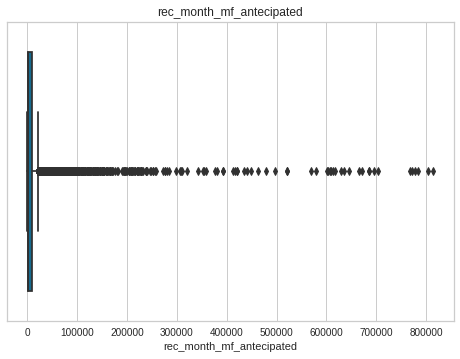

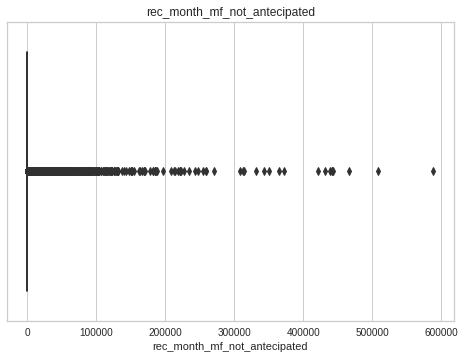

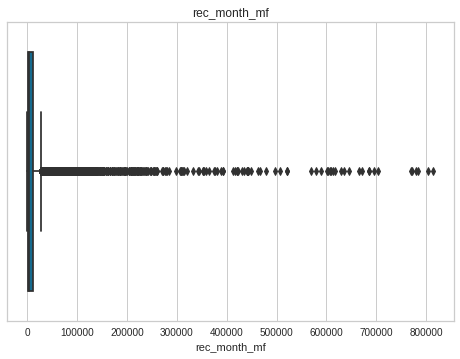

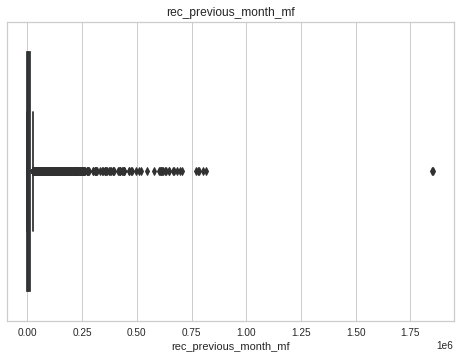

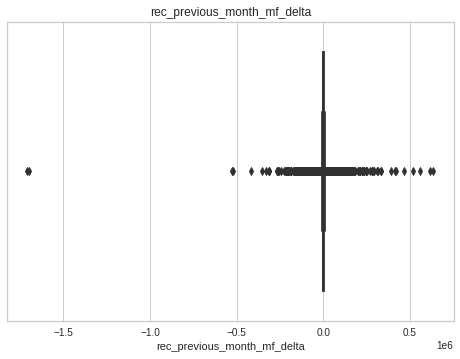

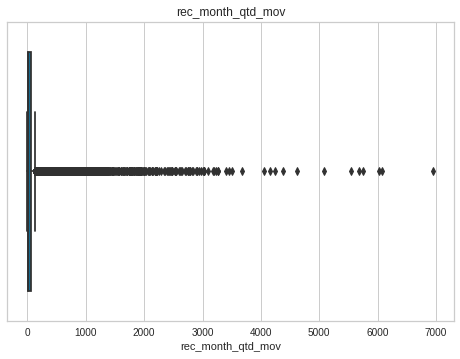

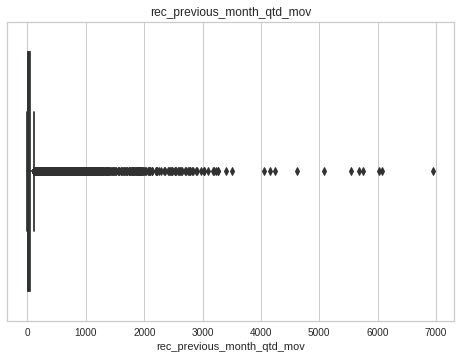

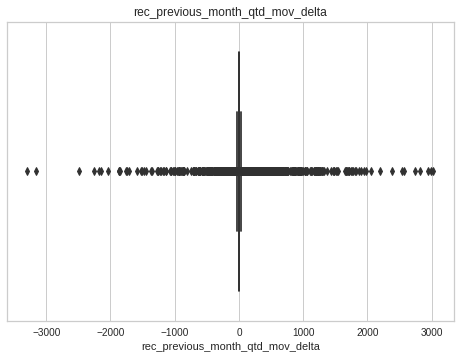

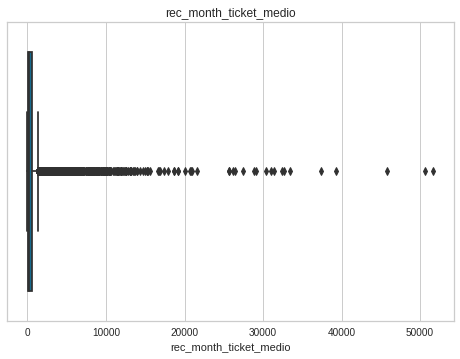

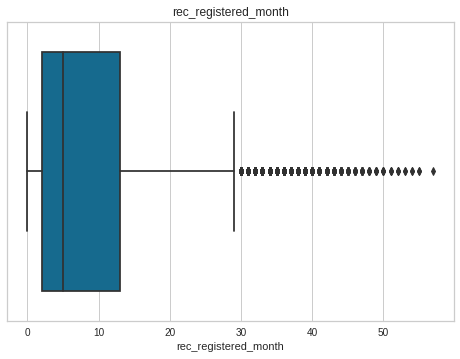

In [ ]:
# selecionar apenas as colunas numéricas
numeric_cols = df_ativo.select_dtypes(include=['int', 'float']).columns.tolist()

# criar um gráfico boxplot para cada coluna numérica avaliando apenas as linhas em que os lojistas estiveram ativ
for col in numeric_cols:
    sns.boxplot(x=df_ativo[col])
    plt.title(col)
    plt.show()

In [ ]:
df_rfm = (
    
  df_ativo.groupby('rec_est_id')
  .agg(
      R = ('rec_month', lambda x: (pd.Timestamp.today() - x.max()).days), # Recência - Há quanto tempo o lojista não realiza transação em dias.
      F = ('rec_month','nunique'), # Frequência - Quantos meses o lojista foi ativo (realizou transação).
      M = ('rec_month_mf', 'mean'), # Ticket Médio por mês - A média das transações mensais do lojista
      S = ('rec_month_mf', 'sum')   # Somatório Faturamento - O somatório das transações do lojista durante os meses ativos
  ).reset_index()
)

In [ ]:
df_rfm

,rec_est_id,R,F,M,S
0,1,48,13,14997.765385,194970.95
1,49,79,4,238.675000,954.70
2,89,385,3,3736.666667,11210.00
3,109,48,1,5.500000,5.50
4,112,354,4,9025.800000,36103.20
...,...,...,...,...,...
5625,30481,48,1,5.000000,5.00
5626,30484,48,1,0.100000,0.10
5627,30503,48,1,110.000000,110.00
5628,30504,48,1,0.010000,0.01


In [ ]:
df_rfm.F.value_counts()

1     2222
2     1056
3      583
4      399
5      323
7      308
6      279
9      134
8      119
14      98
13      31
10      29
11      28
12      21
Name: F, dtype: int64

In [ ]:
df[df['rec_est_id']==49]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_new_category
183229,49,2022-01-01,1,2022,666.1,0.0,666.1,0.0,666.1,12,0,12,55.51,Recuperação,45.0,Ativo
31468,49,2022-02-01,2,2022,187.0,0.0,187.0,666.1,-479.1,2,12,-10,93.50,Recorrente,46.0,Ativo
186744,49,2022-03-01,3,2022,0.0,0.0,0.0,187.0,-187.0,0,2,-2,0.00,Perda,47.0,Inativo
104934,49,2022-04-01,4,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,48.0,Inativo
188796,49,2022-05-01,5,2022,2.6,0.0,2.6,0.0,2.6,1,0,1,2.60,Recuperação,49.0,Ativo
183230,49,2022-06-01,6,2022,0.0,0.0,0.0,2.6,-2.6,0,1,-1,0.00,Perda,50.0,Inativo
90154,49,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,51.0,Inativo
121552,49,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,52.0,Inativo
41720,49,2022-09-01,9,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,53.0,Inativo
121553,49,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.00,Churn,54.0,Inativo


In [ ]:
df_ativo['rec_est_id'].value_counts()

21961    14
9048     14
21414    14
21351    14
21344    14
         ..
21642     1
21651     1
21652     1
21653     1
30507     1
Name: rec_est_id, Length: 5630, dtype: int64

In [ ]:
df.rec_est_id.value_counts()

1        14
18688    14
18620    14
18626    14
18634    14
         ..
30083     1
27216     1
30086     1
30088     1
30507     1
Name: rec_est_id, Length: 6469, dtype: int64

Pode-se observar, através das duas células de código acima que a quantidade de clientes totais está diferente da quantidade de clientes no mês de fevereiro de 2023. Isso provavelmente foi um erro na hora da filtragem realizada pelo autor, pois a quantidade de cliente mês a mês deveria ser acumulativa. Logo, será analisado sobre os clientes que não estão presente no mês atual.

In [ ]:

# Verificando os IDs que estão em df1, mas não em df2
ids_nao_presentes = df[~df['rec_est_id'].isin(df_ativo['rec_est_id'])]['rec_est_id']
ids_nao_presentes_frame = ids_nao_presentes.to_frame()
ids_nao_presentes_frame

,rec_est_id
186752,326
74950,326
51076,326
41,326
170275,326
...,...
186087,22090
111359,22090
7233,22090
70801,22090


In [ ]:
df[df['rec_est_id']==368]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_new_category
105009,368,2022-01-01,1,2022,0.0,0.0,0.0,8744.0,-8744.0,0,13,-13,0.0,Perda,39.0,Inativo
113928,368,2022-02-01,2,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,40.0,Inativo
50,368,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,41.0,Inativo
183330,368,2022-04-01,4,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,42.0,Inativo
1381,368,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,43.0,Inativo
105010,368,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,44.0,Inativo
170282,368,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,45.0,Inativo
53338,368,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,46.0,Inativo
128484,368,2022-09-01,9,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,47.0,Inativo
53339,368,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,48.0,Inativo


In [ ]:
df[df['rec_est_id'].isin(ids_nao_presentes)].rec_monthly_category.value_counts()

Churn    9410
Perda     839
Name: rec_monthly_category, dtype: int64

Pode-se obeservar justamente que os clientes que não constam no dataset relacionado ao mês de fevereiro de 2023 são os clientes que no primeiro mês do dataset foram considerado perdas e depois não retornaram mais. De fato o autor não se atentou a esses clientes na hora que fez a filtragem. Como também há poucas informações sobre esses lojistas, o autor optou por remover as linhas relacionadas a esses ids. Para demonstrar problemas enfrentados durante a execução do desafio, a remoção será feita agora e não no começo do código como seria feita em outro tipo de entrega de projeto.

In [ ]:
# Fazendo uma lista dos IDs que queremos remover
ids_remover = ids_nao_presentes_frame['rec_est_id'].tolist()

# Removendo os IDs de df_rfm que estão presentes em ids_df1
df = df[~df['rec_est_id'].isin(ids_remover)]

df.rec_est_id.value_counts()

1        14
17001    14
17170    14
21599    14
21598    14
         ..
30088     1
30090     1
29761     1
30093     1
30507     1
Name: rec_est_id, Length: 5630, dtype: int64

In [ ]:
df_rfm.rec_est_id.value_counts()

1        1
26773    1
26782    1
26781    1
26779    1
        ..
19225    1
19204    1
19203    1
19199    1
30507    1
Name: rec_est_id, Length: 5630, dtype: int64

Nesse momento, o autor possui todos os lojistas que farão parte do processo de clusterização.

In [ ]:
df_ativo[df_ativo['rec_est_id']==89]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_new_category
183235,89,2022-01-01,1,2022,2991.0,0.0,2991.0,2514.0,477.0,13,16,-3,230.08,Recorrente,44.0,Ativo
31479,89,2022-02-01,2,2022,4673.0,0.0,4673.0,2991.0,1682.0,22,13,9,212.41,Recorrente,45.0,Ativo
70865,89,2022-03-01,3,2022,3546.0,0.0,3546.0,4673.0,-1127.0,15,22,-7,236.40,Recorrente,46.0,Ativo


In [ ]:
df

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_new_category
185071,1,2022-01-01,1,2022,838.80,0.00,838.80,0.00,838.80,5,0,5,167.76,Recuperação,24.0,Ativo
185067,1,2022-02-01,2,2022,7802.59,0.00,7802.59,838.80,6963.79,93,5,88,83.90,Recorrente,25.0,Ativo
190800,1,2022-03-01,3,2022,2.00,0.00,2.00,7802.59,-7800.59,2,93,-91,1.00,Recorrente,26.0,Ativo
185070,1,2022-04-01,4,2022,0.00,1000.00,1000.00,2.00,998.00,1,2,-1,1000.00,Recorrente,27.0,Ativo
192772,1,2022-05-01,5,2022,0.00,1165.74,1165.74,1000.00,165.74,2,1,1,582.87,Recorrente,28.0,Ativo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10161,30481,2023-02-01,2,2023,5.00,0.00,5.00,0.00,5.00,1,0,1,5.00,Novo,0.0,Ativo
29508,30484,2023-02-01,2,2023,0.10,0.00,0.10,0.00,0.10,1,0,1,0.10,Novo,0.0,Ativo
26034,30503,2023-02-01,2,2023,110.00,0.00,110.00,0.00,110.00,1,0,1,110.00,Novo,0.0,Ativo
23302,30504,2023-02-01,2,2023,0.01,0.00,0.01,0.00,0.01,1,0,1,0.01,Novo,0.0,Ativo


In [ ]:
# Com o intuito de gerar uma feature que indique a frequência relativa de meses ativos dos lojistas, gerou-se esse dataset que possuía o ID e ao lado o tempo de observação do mesmo. Ou seja quantos registros um determinado ID tem no banco de dados.
df_tempo_observado = df.rec_est_id.value_counts().to_frame().reset_index()

In [ ]:
df_tempo_observado

,index,rec_est_id
0,1,14
1,17001,14
2,17170,14
3,21599,14
4,21598,14
...,...,...
5625,30088,1
5626,30090,1
5627,29761,1
5628,30093,1


In [ ]:
# Renomeando as colunas e ordenando as linhas de maneira crescente pelo id.
df_tempo_observado.rename(columns={'index': 'rec_est_id', 'rec_est_id': 'tempo_observado'}, inplace = True)
df_tempo_observado = df_tempo_observado.sort_values(by = ['rec_est_id'])
df_tempo_observado

,rec_est_id,tempo_observado
0,1,14
1693,49,14
1541,89,14
1540,109,14
1539,112,14
...,...,...
5457,30481,1
5456,30484,1
5455,30503,1
5454,30504,1


In [ ]:
# Também será interessante analisar a variação média mensal relativa de faturamento que cada lojista possui.

media_por_id = df_ativo.groupby('rec_est_id')['rec_previous_month_mf_delta'].mean().reset_index()
media_por_id

,rec_est_id,rec_previous_month_mf_delta
0,1,1384.423077
1,49,72.150000
2,89,344.000000
3,109,5.500000
4,112,-3652.400000
...,...,...
5625,30481,5.000000
5626,30484,0.100000
5627,30503,110.000000
5628,30504,0.010000


In [ ]:
df_total = pd.merge(df_rfm, df_tempo_observado, on='rec_est_id', how='right')
df_total = pd.merge(df_total, media_por_id, on='rec_est_id', how='right')
df_total

,rec_est_id,R,F,M,S,tempo_observado,rec_previous_month_mf_delta
0,1,48,13,14997.765385,194970.95,14,1384.423077
1,49,79,4,238.675000,954.70,14,72.150000
2,89,385,3,3736.666667,11210.00,14,344.000000
3,109,48,1,5.500000,5.50,14,5.500000
4,112,354,4,9025.800000,36103.20,14,-3652.400000
...,...,...,...,...,...,...,...
5625,30481,48,1,5.000000,5.00,1,5.000000
5626,30484,48,1,0.100000,0.10,1,0.100000
5627,30503,48,1,110.000000,110.00,1,110.000000
5628,30504,48,1,0.010000,0.01,1,0.010000


# # 3. Preparação de dados

In [ ]:
# Gerando uma feature que indica a porcentagem de meses ativos de um lojista em relação ao total de meses de observação do mesmo.
df_total['freq_ativo_perc'] = 100*(df_total['F']/df_total['tempo_observado'])

# Gerando uma feature que indica a porcentagem do delta da transação realizada pelo cliente entre o mês atual e o anterior .
df_total['variacao_mensal_perc'] = 100*(df_total['rec_previous_month_mf_delta']/df_total['M'])
df_total

,rec_est_id,R,F,M,S,tempo_observado,rec_previous_month_mf_delta,freq_ativo_perc,variacao_mensal_perc
0,1,48,13,14997.765385,194970.95,14,1384.423077,92.857143,9.230862
1,49,79,4,238.675000,954.70,14,72.150000,28.571429,30.229391
2,89,385,3,3736.666667,11210.00,14,344.000000,21.428571,9.206066
3,109,48,1,5.500000,5.50,14,5.500000,7.142857,100.000000
4,112,354,4,9025.800000,36103.20,14,-3652.400000,28.571429,-40.466219
...,...,...,...,...,...,...,...,...,...
5625,30481,48,1,5.000000,5.00,1,5.000000,100.000000,100.000000
5626,30484,48,1,0.100000,0.10,1,0.100000,100.000000,100.000000
5627,30503,48,1,110.000000,110.00,1,110.000000,100.000000,100.000000
5628,30504,48,1,0.010000,0.01,1,0.010000,100.000000,100.000000


In [ ]:
# Realizando uma normalização dos dados através da função PowerTransformer

scaler = PowerTransformer()
df_total_scaled = pd.DataFrame(scaler.fit_transform(df_total), index=df_total.index, columns=df_total.columns)
df_total_scaled

,rec_est_id,R,F,M,S,tempo_observado,rec_previous_month_mf_delta,freq_ativo_perc,variacao_mensal_perc
0,-2.069239,-1.249435,1.807212,1.112115,1.702369,1.058013,-0.003210,1.123343,-0.658417
1,-2.068999,-0.877220,0.822024,-0.843770,-0.521703,1.058013,-0.129867,-0.109873,-0.366990
2,-2.068660,0.897432,0.478359,0.325924,0.377213,1.058013,-0.106219,-0.389368,-0.658660
3,-2.068457,-1.249435,-1.081726,-1.833867,-1.833345,1.058013,-0.134829,-1.364887,1.382521
4,-2.068425,0.774732,0.822024,0.806989,0.879102,1.058013,-0.238534,-0.109873,-0.754303
...,...,...,...,...,...,...,...,...,...
5625,1.369330,-1.249435,-1.081726,-1.850671,-1.849955,-1.820807,-0.134860,1.205374,1.382521
5626,1.369835,-1.249435,-1.081726,-2.166006,-2.175283,-1.820807,-0.135155,1.205374,1.382521
5627,1.373031,-1.249435,-1.081726,-1.098744,-1.160145,-1.820807,-0.126791,1.205374,1.382521
5628,1.373200,-1.249435,-1.081726,-2.179984,-2.190378,-1.820807,-0.135160,1.205374,1.382521


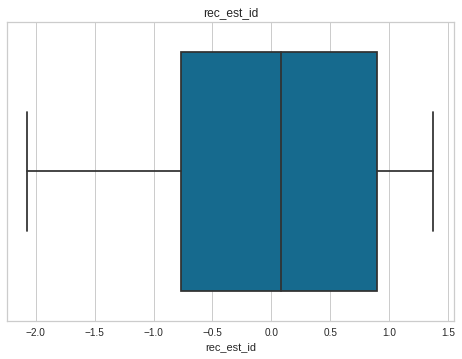

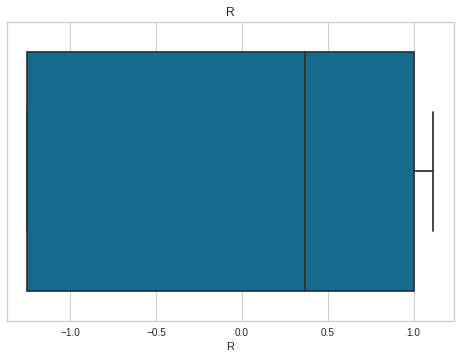

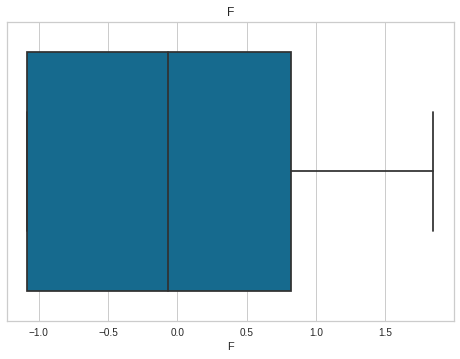

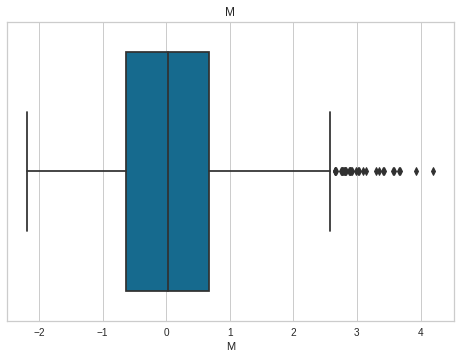

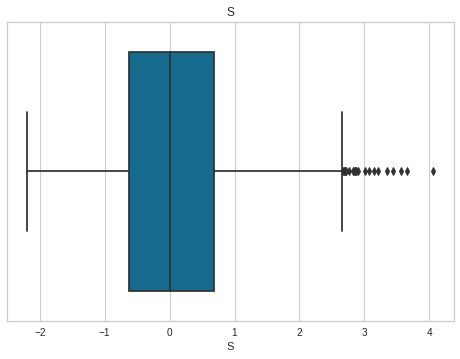

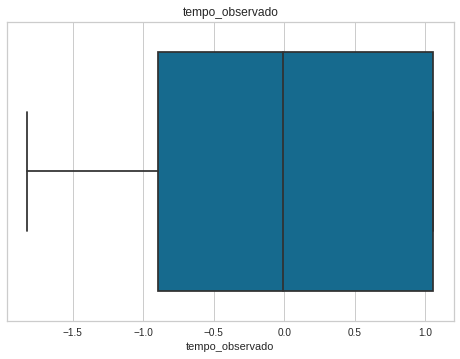

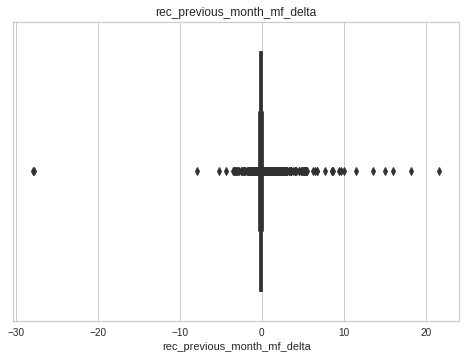

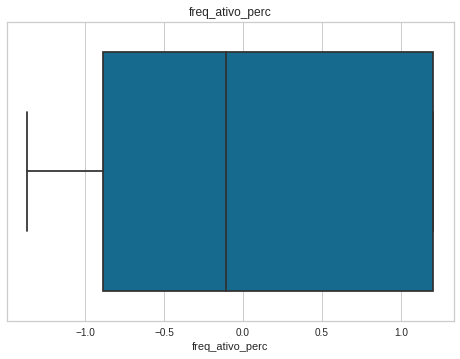

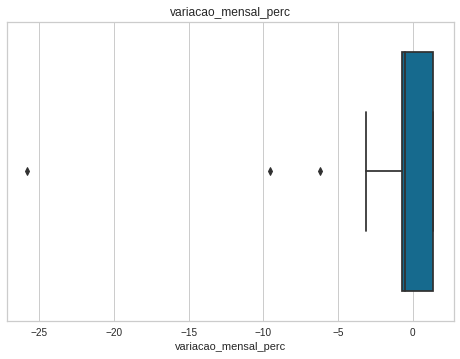

In [ ]:
# selecionar apenas as colunas numéricas
numeric_cols = df_total_scaled.select_dtypes(include=['int', 'float']).columns.tolist()

# criar um gráfico boxplot para cada coluna numérica
for col in numeric_cols:
    sns.boxplot(x=df_total_scaled[col])
    plt.title(col)
    plt.show()

# 4.1.1.  K-means #

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

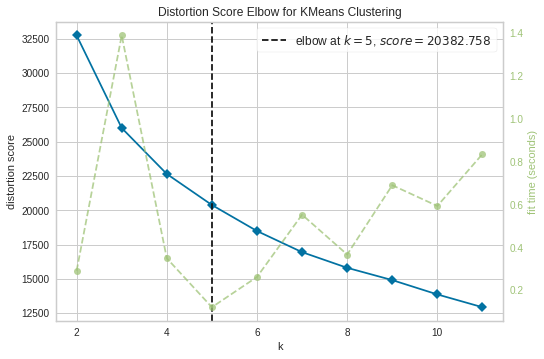

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=11), k=11)

In [ ]:
# Por questões de negócio, o autor tentará identificar a viabilidade de utilizar 10 clusters para melhor explicar o comportamento do cliente.
# Foi gerado o gráfico de Kelbow para verificar se, quando aplica-se uma quantidade maior de cluster do que o ideal, as métricas ainda são aceitáveis para o objetivo do negócio.
kelbow_visualizer(KMeans(),df_total_scaled, k = 11)

In [ ]:
# Verificando as métricas de acordo com o valor de K.

cluster_metrics =  silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range (2,11):
  model = KMeans(n_clusters = k, random_state = 0)
  labels = model.fit_predict(df_total_scaled)
  cluster_results_dict = {'k' : k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(df_total_scaled,labels)
  cluster_metrics_results.append(cluster_results_dict)

cluster_metrics_results

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()
 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,32747.938746,0.362658,1.166822,3080.052199
3,25995.379733,0.347917,1.138160,2670.558057
4,22645.328916,0.313611,1.168637,2320.815355
5,20707.145744,0.293590,1.252727,2034.817561
6,18483.336187,0.304443,1.150356,1958.718030
7,16943.409542,0.306188,0.998411,1865.472443
8,15801.623333,0.293309,1.045997,1772.242431
9,14758.926212,0.298496,1.062517,1709.610703
10,13820.899716,0.292031,1.079649,1664.885530


In [ ]:
# Aplicando com k = 7, modelo ideal segundo a métrica davies_bouldin_score.
model = KMeans(7, random_state = 0).fit(df_total_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
#Gerando o centróide e labels do modelo.
centroids = model.cluster_centers_
labels = model.labels_

In [ ]:
pd.DataFrame(centroids, columns = df_total_scaled.columns)

,rec_est_id,R,F,M,S,tempo_observado,rec_previous_month_mf_delta,freq_ativo_perc,variacao_mensal_perc
0,-0.997692,0.127662,0.975263,0.319163,0.561281,0.768914,-0.114839,0.263954,-0.555684
1,0.847966,-1.121151,1.059028,0.747837,0.945693,-0.600592,0.142111,1.083984,-0.456225
2,-0.185307,0.646412,-0.928485,-1.017171,-1.102450,0.308367,-0.060652,-0.971061,1.321296
3,-0.779203,1.029084,-0.625374,-0.072529,-0.257611,0.751620,-0.261905,-0.947681,-0.689490
4,1.026711,-0.738795,-0.575284,-0.442546,-0.551151,-1.377299,0.114370,0.691288,1.044978
5,0.776549,-0.882944,0.309253,2.557632,1.990454,-0.781910,7.260422,0.835210,0.274563
6,-1.042558,1.114831,-1.081726,2.802674,1.566007,1.058013,-27.811123,-1.364887,-0.906965


In [ ]:
pd.DataFrame(centroids, columns = df_total_scaled.columns).T.add_prefix('Grupo_')

,Grupo_0,Grupo_1,Grupo_2,Grupo_3,Grupo_4,Grupo_5,Grupo_6
rec_est_id,-0.997692,0.847966,-0.185307,-0.779203,1.026711,0.776549,-1.042558
R,0.127662,-1.121151,0.646412,1.029084,-0.738795,-0.882944,1.114831
F,0.975263,1.059028,-0.928485,-0.625374,-0.575284,0.309253,-1.081726
M,0.319163,0.747837,-1.017171,-0.072529,-0.442546,2.557632,2.802674
S,0.561281,0.945693,-1.102450,-0.257611,-0.551151,1.990454,1.566007
tempo_observado,0.768914,-0.600592,0.308367,0.751620,-1.377299,-0.781910,1.058013
rec_previous_month_mf_delta,-0.114839,0.142111,-0.060652,-0.261905,0.114370,7.260422,-27.811123
freq_ativo_perc,0.263954,1.083984,-0.971061,-0.947681,0.691288,0.835210,-1.364887
variacao_mensal_perc,-0.555684,-0.456225,1.321296,-0.689490,1.044978,0.274563,-0.906965


In [ ]:
centers = pd.DataFrame(centroids, columns = df_total_scaled.columns)
centers

,rec_est_id,R,F,M,S,tempo_observado,rec_previous_month_mf_delta,freq_ativo_perc,variacao_mensal_perc
0,-0.997692,0.127662,0.975263,0.319163,0.561281,0.768914,-0.114839,0.263954,-0.555684
1,0.847966,-1.121151,1.059028,0.747837,0.945693,-0.600592,0.142111,1.083984,-0.456225
2,-0.185307,0.646412,-0.928485,-1.017171,-1.102450,0.308367,-0.060652,-0.971061,1.321296
3,-0.779203,1.029084,-0.625374,-0.072529,-0.257611,0.751620,-0.261905,-0.947681,-0.689490
4,1.026711,-0.738795,-0.575284,-0.442546,-0.551151,-1.377299,0.114370,0.691288,1.044978
5,0.776549,-0.882944,0.309253,2.557632,1.990454,-0.781910,7.260422,0.835210,0.274563
6,-1.042558,1.114831,-1.081726,2.802674,1.566007,1.058013,-27.811123,-1.364887,-0.906965


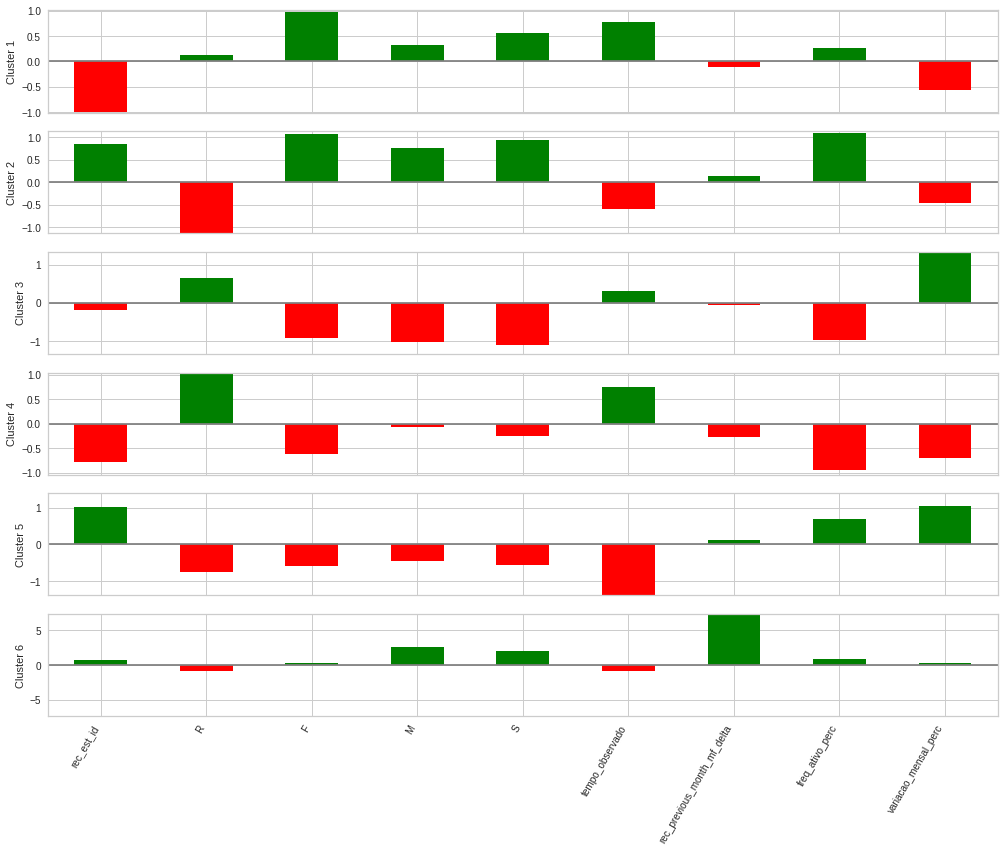

In [ ]:
fig, axes = plt.subplots(nrows = 6, figsize = (14,12), sharex = True)

for i, ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax = ax, color = colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color = 'gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation = 60, ha = 'right')
plt.tight_layout()
plt.show()

In [ ]:
(
df_total_scaled.assign(cluster=labels).groupby('cluster')
.mean()
.transpose()
.style.background_gradient(cmap='YlOrRd')
)

cluster,0,1,2,3,4,5,6
rec_est_id,-0.997215,0.847966,-0.185307,-0.779581,1.026711,0.776549,-1.042558
R,0.126499,-1.121151,0.646412,1.029067,-0.738795,-0.882944,1.114831
F,0.976645,1.059028,-0.928485,-0.625008,-0.575284,0.309253,-1.081726
M,0.317652,0.747837,-1.017171,-0.071530,-0.442546,2.557632,2.802674
S,0.560647,0.945693,-1.102450,-0.256764,-0.551151,1.990454,1.566007
tempo_observado,0.768530,-0.600592,0.308367,0.751820,-1.377299,-0.781910,1.058013
rec_previous_month_mf_delta,-0.114224,0.142111,-0.060652,-0.262111,0.114370,7.260422,-27.811123
freq_ativo_perc,0.265323,1.083984,-0.971061,-0.947563,0.691288,0.835210,-1.364887
variacao_mensal_perc,-0.555405,-0.456225,1.321296,-0.689540,1.044978,0.274563,-0.906965


Verificando  utilizando apenas 3 features (R, F, M)

In [ ]:
df_total_scaled = df_total_scaled[['R','F','M']]

In [ ]:
df_total_scaled

,R,F,M
0,-1.249435,1.807212,1.112115
1,-0.877220,0.822024,-0.843770
2,0.897432,0.478359,0.325924
3,-1.249435,-1.081726,-1.833867
4,0.774732,0.822024,0.806989
...,...,...,...
5625,-1.249435,-1.081726,-1.850671
5626,-1.249435,-1.081726,-2.166006
5627,-1.249435,-1.081726,-1.098744
5628,-1.249435,-1.081726,-2.179984


In [ ]:
# Create List of ditctionaries

cluster_metrics =  silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range (2,11):
  model = KMeans(n_clusters = k, random_state = 0)
  labels = model.fit_predict(df_total_scaled)
  cluster_results_dict = {'k' : k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(df_total_scaled,labels)
  cluster_metrics_results.append(cluster_results_dict)

cluster_metrics_results

#Create Dataframe
pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()
 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8388.980324,0.451811,0.880649,5703.178994
3,6355.333254,0.376534,1.077316,4663.706862
4,5221.227188,0.356655,1.045498,4191.158636
5,4211.800944,0.379376,0.968813,4233.052897
6,3591.267095,0.358743,0.957310,4165.239878
7,3121.132568,0.350301,0.931880,4134.364263
8,2753.404410,0.359677,0.925850,4123.567191
9,2469.231554,0.365678,0.937450,4103.502239
10,2256.546548,0.359901,0.921800,4049.460073


In [ ]:
# Ao invés de usar o K indicado pelas métricas acima, o autor usará uma quantidade maior, 10 clusters, visando tentar representar a maior variação entre os lojistas.
# Para validar se o modelo consegue explicar bem as variações com essa quantidade de clusters, será necessário análises gráficas e mais manuais referentes a essa aplicação.
model = KMeans(n_clusters = 10, random_state = 0)
labels = model.fit_predict(df_total_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
px.scatter_3d(df_total_scaled, x='R',y='F',z='M', color= labels, template = 'plotly_dark')

<Axes: xlabel='R', ylabel='F'>

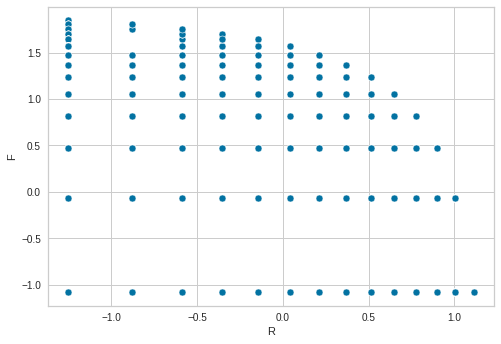

In [ ]:
sns.scatterplot(data = df_total_scaled, x='R',y='F')

<Axes: xlabel='R', ylabel='M'>

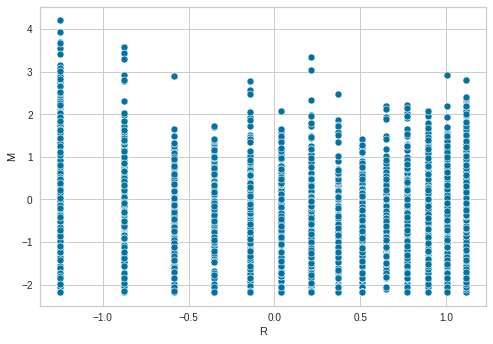

In [ ]:
sns.scatterplot(data = df_total_scaled, x='R',y='M')

<Axes: xlabel='F', ylabel='M'>

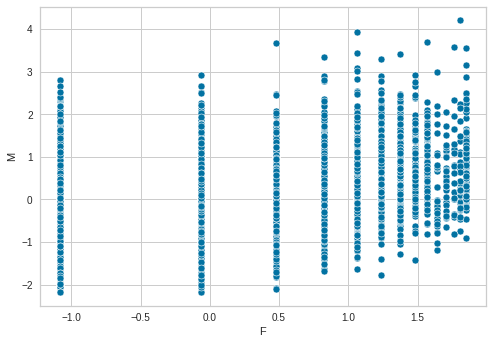

In [ ]:
sns.scatterplot(data = df_total_scaled, x='F',y='M')

In [ ]:
(
df_total_scaled.assign(cluster=labels).groupby('cluster')
.mean()
.style.background_gradient(cmap='YlOrRd')
)

,R,F,M
cluster,,,
0,1.020665,-1.081726,0.716874
1,0.727112,0.361208,0.712978
2,0.680792,-1.025407,-1.682576
3,-1.155950,1.183647,1.567176
4,-1.054079,-0.669563,0.408173
5,0.952440,-1.081726,-0.442454
6,0.805955,0.219726,-0.510129
7,-0.854017,0.531313,-0.513510
8,-1.144368,1.233452,0.441656


Notas: 1 a 5, onde 1 significa a escala mais baixa possível e 5 a maior escala.
  
Grupo 0 - Churns com alto potencial - 

(Lojistas perdidos com baixa frequência e alto faturamento): 

         Recência: 5
         Frequência: 1
         Faturamento Mensal Médio: 3

Grupo 1 - Não podem perdê-los -

(Lojistas quase perdidos com frequência e faturamento altos) : 

         Recência: 4
         Frequência: 3 
         Faturamento Mensal Médio: 3

Grupo 2 - Prestes a churn - 

(Lojistas quase perdidos com frequência e faturamento baixos): 

         Recência: 4
         Frequência: 1
         Faturamento Mensal Médio: 1

Grupo 3 - Campeões -

(Lojistas ativos com frequência e faturamento muito altos): 

         Recência: 1
         Frequência: 5
         Faturamento Mensal Médio: 5

Grupo 4 - Promessas -

(Lojistas Recentes com alto faturamente e potencial): 

         Recência: 1
         Frequência: 1
         Faturamento Mensal Médio: 3
 

Grupo 5 - Churns com pouco potencial - 

(Lojistas perdidos com baixa frequência e regular faturamento: 

         Recência: 5
         Frequência: 1 
         Faturamento Mensal Médio: 2

Grupo 6 - Precisam de atenção -

(Lojistas quase perdidos com alta frequência e regular faturamento ): 

         Recência: 4
         Frequência: 3
         Faturamento Mensal Médio: 2

Grupo 7 - Potenciais -

(Lojistas ativos com alta frequência e regular faturamento):  

         Recência: 1
         Frequência: 3 
         Faturamento Mensal Médio: 2

Grupo 8 - Leais -

(Lojistas ativos com frequência muito alta e com alto faturamento): 
         
         Recência: 1
         Frequência: 5 
         Faturamento Mensal Médio: 3
         

Grupo 9 - Novos Lojistas - 

(Lojistas Recentes com baixo faturamento e potencial): 

         Recência: 1
         Frequência: 1
         Faturamento Mensal Médio: 1

 





#Conclusões K-means#

Como é possível observar no gráfico plotado acima, o melhor modelo para clusters, ou seja, aquele que melhor explica um grupo e que possui menos dispersão ocorre quando é feito levando em conta uma quantidade menor de features, que são elas: Recência, Frequência e Faturamento médio mensal (R, F e M). O autor acredita que isso ocorra pelo fato de o dataset possuir dados com uma densidade homogênea e com um histórico de data recente. Entretanto, caso se utilize todas as informações do dataset, levando em consideração um período de tempo maior, acredita-se que informações como frequência relativa de atividade, delta médio mensal de faturamento com o lojista e outras features possam ter uma relevância maior para o modelo. 

Portanto, por questões de negócios, como o dataset possui informações de transações apenas dos últimos 14 meses, o autor irá preferir seguir com a análise de outros clusters utilizando apenas as 3 variáveis citadas acima.

# 4.1.2. Resultados e avaliação K-means

In [ ]:
grupos = pd.DataFrame(labels, columns = ['rec_grupo'])

In [ ]:
grupos

,rec_grupo
0,3
1,7
2,1
3,9
4,1
...,...
5625,9
5626,9
5627,9
5628,9


In [ ]:
grupos.value_counts()

rec_grupo
8            949
5            836
6            701
1            561
3            550
2            523
0            502
7            447
4            345
9            216
dtype: int64

In [ ]:
df_total

,rec_est_id,R,F,M,S,tempo_observado,rec_previous_month_mf_delta,freq_ativo_perc,variacao_mensal_perc
0,1,48,13,14997.765385,194970.95,14,1384.423077,92.857143,9.230862
1,49,79,4,238.675000,954.70,14,72.150000,28.571429,30.229391
2,89,385,3,3736.666667,11210.00,14,344.000000,21.428571,9.206066
3,109,48,1,5.500000,5.50,14,5.500000,7.142857,100.000000
4,112,354,4,9025.800000,36103.20,14,-3652.400000,28.571429,-40.466219
...,...,...,...,...,...,...,...,...,...
5625,30481,48,1,5.000000,5.00,1,5.000000,100.000000,100.000000
5626,30484,48,1,0.100000,0.10,1,0.100000,100.000000,100.000000
5627,30503,48,1,110.000000,110.00,1,110.000000,100.000000,100.000000
5628,30504,48,1,0.010000,0.01,1,0.010000,100.000000,100.000000


In [ ]:
df_resultado = df_total.merge(grupos, how='inner', left_index=True, right_index=True)


In [ ]:
df_resultado.head(50)

,rec_est_id,R,F,M,S,tempo_observado,rec_previous_month_mf_delta,freq_ativo_perc,variacao_mensal_perc,rec_grupo
0,1,48,13,14997.765385,194970.95,14,1384.423077,92.857143,9.230862,3
1,49,79,4,238.675000,954.70,14,72.150000,28.571429,30.229391,7
2,89,385,3,3736.666667,11210.00,14,344.000000,21.428571,9.206066,1
3,109,48,1,5.500000,5.50,14,5.500000,7.142857,100.000000,9
4,112,354,4,9025.800000,36103.20,14,-3652.400000,28.571429,-40.466219,1
5,113,48,14,11541.937143,161587.12,14,672.000000,100.000000,5.822246,8
6,115,354,4,6856.500000,27426.00,14,-2355.100000,28.571429,-34.348428,1
7,120,140,11,8051.516364,88566.68,14,-5976.990909,78.571429,-74.234351,8
8,121,444,1,10681.000000,10681.00,14,-1143.400000,7.142857,-10.704990,0
9,199,385,2,1642.100000,3284.20,4,1642.100000,50.000000,100.000000,6


In [ ]:
df_resultado.tail(50)

,rec_est_id,R,F,M,S,tempo_observado,rec_previous_month_mf_delta,freq_ativo_perc,variacao_mensal_perc,rec_grupo
5580,30360,48,1,1800.00,1800.00,1,1800.00,100.0,100.0,4
5581,30362,48,1,314.06,314.06,1,314.06,100.0,100.0,9
5582,30363,48,1,253.60,253.60,1,253.60,100.0,100.0,9
5583,30365,48,1,1175.43,1175.43,1,1175.43,100.0,100.0,4
5584,30367,48,1,1000.00,1000.00,1,1000.00,100.0,100.0,4
5585,30368,48,1,90.00,90.00,1,90.00,100.0,100.0,9
5586,30370,48,1,33087.85,33087.85,1,33087.85,100.0,100.0,4
5587,30371,48,1,142.98,142.98,1,142.98,100.0,100.0,9
5588,30375,48,1,13141.30,13141.30,1,13141.30,100.0,100.0,4
5589,30376,48,1,1076.49,1076.49,1,1076.49,100.0,100.0,4


In [ ]:
df_resultado.head(50)

,rec_est_id,R,F,M,S,tempo_observado,rec_previous_month_mf_delta,freq_ativo_perc,variacao_mensal_perc,rec_grupo
0,1,48,13,14997.765385,194970.95,14,1384.423077,92.857143,9.230862,3
1,49,79,4,238.675000,954.70,14,72.150000,28.571429,30.229391,7
2,89,385,3,3736.666667,11210.00,14,344.000000,21.428571,9.206066,1
3,109,48,1,5.500000,5.50,14,5.500000,7.142857,100.000000,9
4,112,354,4,9025.800000,36103.20,14,-3652.400000,28.571429,-40.466219,1
5,113,48,14,11541.937143,161587.12,14,672.000000,100.000000,5.822246,8
6,115,354,4,6856.500000,27426.00,14,-2355.100000,28.571429,-34.348428,1
7,120,140,11,8051.516364,88566.68,14,-5976.990909,78.571429,-74.234351,8
8,121,444,1,10681.000000,10681.00,14,-1143.400000,7.142857,-10.704990,0
9,199,385,2,1642.100000,3284.20,4,1642.100000,50.000000,100.000000,6


# 4.3.  Cluster Hierárquico

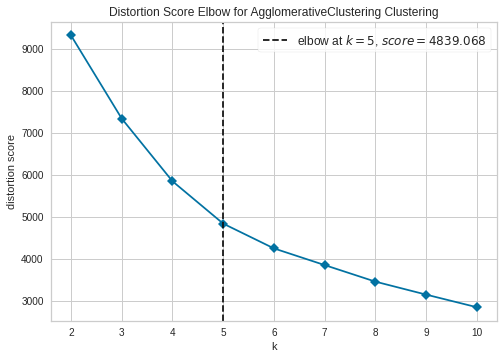

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [ ]:
kelbow_visualizer(AgglomerativeClustering(), df_total_scaled, k=10, timings=False)

In [ ]:


cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_total_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}

  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.415979,0.831666,4564.948683
3,0.318317,1.391553,3657.532103
4,0.327458,1.154134,3539.196670
5,0.340954,1.170936,3502.043084
6,0.354914,1.061358,3347.041339
7,0.340544,1.040766,3173.291499
8,0.315303,1.058414,3122.086113
9,0.299313,1.014855,3068.895484
10,0.312758,0.982066,3081.392549


In [ ]:
hclust = AgglomerativeClustering(n_clusters=10)
hclust_labels = hclust.fit_predict(df_total_scaled)

In [ ]:
px.scatter_3d(df_total_scaled, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

In [ ]:
(
df_total_scaled.assign(cluster=hclust_labels).groupby('cluster')
.mean()
.style.background_gradient(cmap='YlOrRd')
)

,R,F,M
cluster,,,
0,0.411675,-0.998596,-1.597803
1,-0.559801,0.448791,-0.179336
2,0.896712,-1.081726,-0.178693
3,-1.154164,1.318946,0.413146
4,0.745876,0.231227,-0.529473
5,0.771037,0.347397,0.904700
6,-1.102809,-1.081726,0.110864
7,-1.226782,1.420109,1.817142
8,1.106671,-1.081726,1.030915


#4.4. Gaussian Mixture

In [ ]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']
X = df_total_scaled.copy()

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
30,-34921.706904,8,diag
28,-34269.413346,8,full
24,-32500.037122,7,full
26,-32404.573996,7,diag
22,-29245.931988,6,diag


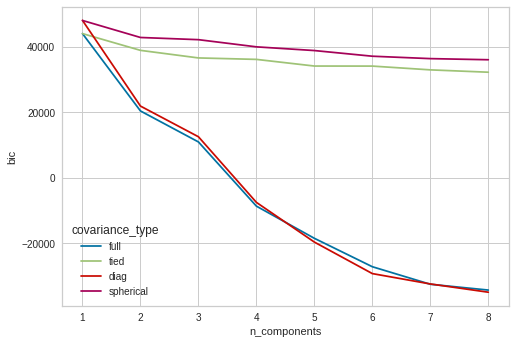

In [ ]:
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');mclust = GaussianMixture(n_components=5, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_total_scaled)

In [ ]:
mclust = GaussianMixture(n_components=10, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_total_scaled)

In [ ]:
px.scatter_3d(df_total_scaled, x='R', y='F', z='M', color=mclust_labels.astype(str), template='plotly_dark')

Visualmente, pode-se perceber que os modelos de cluster Hierárquico e Gaussian Mixture possuem mais dispersões e maior desvio padrão em seus grupos, portanto o autor irá preferir optar pelo modelo K-means, caso o DBSCAN também não consiga fornecer bons resultados.

# 4.5. DBSCAN

In [ ]:
# Determinando o parâmetros eps através dos NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

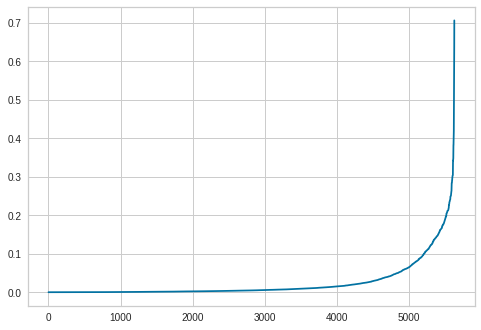

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
m = DBSCAN(eps=0.3, min_samples=3)
m.fit(X)

In [ ]:
clusters = m.labels_

In [ ]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

In [ ]:
px.scatter_3d(df_total_scaled, x='R', y='F', z='M', color=clusters, template='plotly_dark')

Percebe-se que o DBSCAN para essa massa de dados também não explica tão bem quanto o K-means o comportamento dos lojistas, sejam eles recorrentes, iminentes de saída ou churns. Essa observação se deve ao fato de que a dispersão dos dados em relação aos centróides é maior do que a dos outros modelos, principalmente a do K-means.

#  # 5. Análises de cada grupo #

In [ ]:
# Análise descritiva dos dados de acordo com as classificações.

for i in range (0,9):
  print('')
  print(f'Grupo {i}')
  print('')
  print('Recência')
  print(df_resultado[df_resultado['rec_grupo']==i].R.value_counts())
  print('')
  print('Frequência')
  print(df_resultado[df_resultado['rec_grupo']==i].F.value_counts())
  print('')
  print('Ticket Médio')
  print(df_resultado[df_resultado['rec_grupo']==i].M.describe())
  print('')


Grupo 0

Recência
444    413
413     17
385     13
293     13
354     10
201     10
263      8
324      7
232      7
171      4
Name: R, dtype: int64

Frequência
1    502
Name: F, dtype: int64

Ticket Médio
count       502.000000
mean      11044.965120
std       15149.077933
min        2570.000000
25%        3929.085000
50%        6205.540000
75%       11774.472500
max      151114.880000
Name: M, dtype: float64


Grupo 1

Recência
413    183
385    137
354     64
324     34
263     33
201     30
293     29
232     27
171     20
140      4
Name: R, dtype: int64

Frequência
2    262
3    155
4     72
5     32
6     22
7     11
8      7
Name: F, dtype: int64

Ticket Médio
count       561.000000
mean      10843.231878
std       13507.948580
min        1820.787143
25%        3821.810000
50%        6281.500000
75%       11758.560000
max      169718.685000
Name: M, dtype: float64


Grupo 2

Recência
293    118
444    109
232     54
385     49
413     48
354     41
324     40
201     33
263  

Basicamente, o cluster gerado reproduz subcategorias relacionadas à clientes frequentemente ativos, clientes churns e clientes na iminência de churn. E esses clusters conseguem explicar bem o comportamento geral dos lojistas. Portanto, o modelo K-means consegue ser um modelo eficiente para o conjunto de dados que foi adaptado, preparado e treinado.

# # 6. Classificando os dados com o modelo KNN # 

Será validado se, ao aplicar o modelo supervisionado KNN no dataset gerado para clusterização, ele conseguirá predizer bem possíveis dados futuros que estarão no banco de dados.

In [ ]:
df_total_scaled_classificacao = df_total_scaled.merge(grupos, how='inner', left_index=True, right_index=True)
df_total_scaled_classificacao

,R,F,M,rec_grupo
0,-1.249435,1.807212,1.112115,3
1,-0.877220,0.822024,-0.843770,7
2,0.897432,0.478359,0.325924,1
3,-1.249435,-1.081726,-1.833867,9
4,0.774732,0.822024,0.806989,1
...,...,...,...,...
5625,-1.249435,-1.081726,-1.850671,9
5626,-1.249435,-1.081726,-2.166006,9
5627,-1.249435,-1.081726,-1.098744,9
5628,-1.249435,-1.081726,-2.179984,9


In [ ]:
X = df_total_scaled_classificacao.drop(columns='rec_grupo')
y = df_total_scaled_classificacao['rec_grupo']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state = 1)
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
ypred=knn_clf.predict(X_test)

In [ ]:
result1 = classification_report(y_test, ypred)
print('Classification Report: ',)
print (result1)
result2 = accuracy_score(y_test,ypred)
print('Accuracy:',round(100*result2, 2))

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       128
           1       0.96      0.99      0.97       137
           2       0.98      0.99      0.98       132
           3       0.99      0.97      0.98       144
           4       0.98      0.98      0.98        89
           5       1.00      0.99      0.99       207
           6       0.99      0.97      0.98       180
           7       0.97      0.99      0.98       114
           8       0.99      0.99      0.99       232
           9       1.00      0.98      0.99        45

    accuracy                           0.99      1408
   macro avg       0.98      0.98      0.98      1408
weighted avg       0.99      0.99      0.99      1408

Accuracy: 98.51


# # 7. Gerando excel de entrega # #

In [ ]:
df_resultado = df_resultado[['rec_est_id',	'R',	'F',	'M',	'S', 'rec_grupo']]

In [ ]:
df_resultado.rename(columns = {'R': 'rec_recência',  'F':'rec_frequência_ativo', 'M': 'rec_faturamento_médio', 'S':'rec_faturamento_total'}, inplace=True)

<ipython-input-112-8b1df7cc0928>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_resultado

,rec_est_id,rec_recência,rec_frequência_ativo,rec_faturamento_médio,rec_faturamento_total,rec_grupo
0,1,48,13,14997.765385,194970.95,3
1,49,79,4,238.675000,954.70,7
2,89,385,3,3736.666667,11210.00,1
3,109,48,1,5.500000,5.50,9
4,112,354,4,9025.800000,36103.20,1
...,...,...,...,...,...,...
5625,30481,48,1,5.000000,5.00,9
5626,30484,48,1,0.100000,0.10,9
5627,30503,48,1,110.000000,110.00,9
5628,30504,48,1,0.010000,0.01,9


In [ ]:
df_resultado.to_excel('resultado_clusterizacao.xlsx', index = False)